In [1]:
import sys
sys.path.insert(1, '/home/samuel/EFARS/')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import random
import albumentations as A

from models.openpose import OpenPose
from models.unipose import UniPose
from data.human36m import Human36M2DPoseDataset, Human36MMetadata
from utils.misc import AverageMeter, seed_everything, normalize, denormalize
from utils.visualization import show_img_with_hmap, show_hmap_with_pos2d

/home/samuel/anaconda3/envs/pose/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(2333)

root_path = '/home/samuel/h36m'
img_path = root_path + '/imgs'
pos2d_path = root_path + '/pos2d'

img_fns = glob(img_path+'/*.jpg')
random.shuffle(img_fns)
test_fns = img_fns[12000:14000]

In [3]:
def val_transforms(img, pos2d):
    transforms = A.Compose([
        A.Resize(height=256, width=256, p=1)
    ], keypoint_params=A.KeypointParams(format='xy'))

    transformed = transforms(image=img, keypoints=pos2d)
    img = transformed['image']
    img = normalize(img, Human36MMetadata.mean, Human36MMetadata.std)
    pos2d = np.array(transformed['keypoints'])
    return img, pos2d

In [4]:
test_dataset = Human36M2DPoseDataset(test_fns, pos2d_path, transforms=val_transforms, 
    out_size=(256, 256), mode='E', sigma=3)

In [5]:
from collections import OrderedDict
net = UniPose(dataset='human3.6m',num_classes=17)
#net = OpenPose()
checkpoint = torch.load('/home/samuel/EFARS/estimator/checkpoints/UniPose-20-1e-2-plateau-sigma3-newgt/best-checkpoint-007epoch.bin', map_location=torch.device('cpu'))
state_dict = checkpoint['model_state_dict']
new_sd = OrderedDict()
for k, v in state_dict.items():
    new_sd[k[7:]] = v
net.load_state_dict(new_sd)
net.eval()

UniPose(
  (pool_center): AvgPool2d(kernel_size=9, stride=8, padding=1)
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu):

In [6]:
img, hmap, skeleton = test_dataset[888]
img = img.unsqueeze(0)
pred = net(img)
pred = pred.squeeze().detach().numpy()
img = img.squeeze().detach()
skeleton = skeleton.squeeze().numpy()

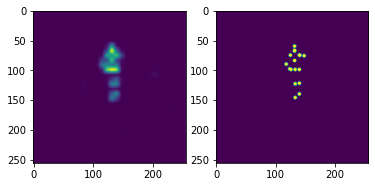

In [8]:
show_hmap_with_pos2d(pred, [img.shape[1],img.shape[2]])

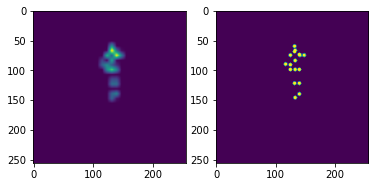

In [9]:
show_hmap_with_pos2d(hmap.numpy(), [img.shape[1],img.shape[2]])

In [10]:
from utils.metrics import accuracy_2d_pose
acc, acc_PCK, acc_PCKh, cnt, pred, visible = accuracy_2d_pose(np.expand_dims(pred, axis=0), hmap.unsqueeze(0).cpu().numpy(), 0.2, 0.5)

In [11]:
print(f'Acc: {acc.mean()}, PCK: {acc_PCK.mean()}, PCKh: {acc_PCKh.mean()}')

Acc: 1.0, PCK: 1.0, PCKh: 1.0
